In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
import pandas as pd
import sys 
import os
sys.path.append(os.path.abspath("/Users/pudong/Desktop"))
import risklib

In [ ]:
#Question 1

In [2]:
# Read in the data
data1 = np.genfromtxt('problem1.csv', delimiter=',')
data1 = np.delete(data1, 0, 0)

# Fit normal distribution.
params_norm = norm.fit(data1)
mean, std = params_norm

# Fit T distribution.
params_t = t.fit(data1)
df, loc, scale = params_t

# Simulation
nsamples = 10000
norm_simulation = norm(mean, std).rvs(nsamples)
t_simulation = t(df, loc, scale).rvs(nsamples)

# Calculate VaR
var_norm = risklib.calculate_var(norm_simulation)
var_t = risklib.calculate_var(t_simulation)
print("Normal distribution VaR: " + str(var_norm))
print("T distribution VaR: " + str(var_t))
print()

# Calculate Expected Shortfall
es_norm = risklib.calculate_es(norm_simulation)
es_t = risklib.calculate_es(t_simulation)
print("Normal distribution ES: " + str(es_norm))
print("T distribution ES: " + str(es_t))

Normal distribution VaR: 0.08083001649793141
T distribution VaR: 0.07341047133790324

Normal distribution ES: 0.10155666084239018
T distribution ES: 0.10820008042369983


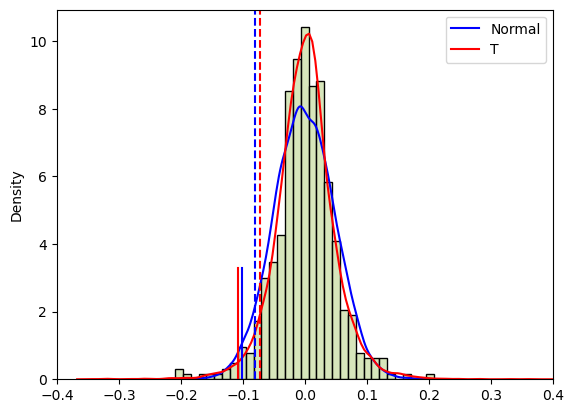

In [3]:
#Figure plot
plt.figure()
norm_color = "b"
t_color = "r"

# Histogram and distributions PDFs
sns.histplot(data1, stat="density", color="#cadea5")
sns.kdeplot(norm_simulation, color=norm_color, label='Normal')
sns.kdeplot(t_simulation, color=t_color, label='T')
plt.axvline(-var_norm, color=norm_color, linestyle='--')
plt.axvline(-var_t, color=t_color, linestyle='--')
plt.axvline(-es_norm, 0, 0.3, color=norm_color)
plt.axvline(-es_t, 0, 0.3, color=t_color)

plt.xlim(-0.4, 0.4)
plt.legend()

plt.show()

In [ ]:
# Question 2

In [5]:
# Covariance estimation techniques Test case
return_data = np.genfromtxt('DailyReturn.csv', delimiter=',').T
return_data = np.delete(return_data, 0, 0)
return_data = np.delete(return_data, 0, 1)
return_data = np.matrix(np.fliplr(return_data))

weights = risklib.calculate_exponential_weights(return_data.shape[1], lamb=0.97)
print(weights.shape)

ew_cov = risklib.calculate_ewcov(return_data, lamb=0.97)
print(ew_cov.shape)

(249,)
(100, 100)


In [6]:
# Non PSD fixes for correlation matrices test case
n = 500
sigma = np.matrix(np.full((n, n), 0.9))
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

def is_psd(matrix, tol=1e-7):
    return np.all(np.linalg.eigvals(matrix) >= -tol)

near_psd_matrix = risklib.near_psd(sigma)
print(is_psd(near_psd_matrix))
higham_psd_matrix = risklib.higham_psd(sigma)
print(is_psd(higham_psd_matrix))

True
True


In [7]:
# Simulation Methods test case
res_d = risklib.direct_simulation(ew_cov)
res_pca = risklib.pca_simulation(ew_cov, pct_explained=0.75)
print(res_d.shape)
print(res_pca.shape)

(100, 25000)
(100, 25000)


In [8]:
# VaR calculation methods (all discussed) test case
sample_return = (return_data[0] - return_data[0].mean()).T
var_norm = risklib.normal_var(sample_return)
var_ew_norm = risklib.ewcov_normal_var(sample_return)
var_t = risklib.t_var(sample_return)
var_hist = risklib.historic_var(sample_return)
print(var_norm, var_ew_norm, var_t, var_hist)

0.024748926964415437 0.018677180480778533 0.024916070020451285 0.026364798323694778


In [9]:
# ES calculation test case
es = risklib.calculate_es(sample_return)
print(es)

0.03340070415446401


In [ ]:
# Question 3

In [10]:
prices = pd.read_csv("DailyPrices.csv", parse_dates=[0], index_col=0)
portfolios = pd.read_csv("portfolio.csv")
returns = risklib.pd_calculate_returns(prices)

# Combine portfolios
total_holdings = portfolios.groupby('Stock').sum('Holding')
total_holdings['Portfolio'] = 'Total'
total_holdings = total_holdings.reset_index()
portfolios = portfolios.append(total_holdings)

/var/folders/fw/6q32dx0x4lsc4ns_jfb1112m0000gn/T/ipykernel_13965/4231478952.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portfolios = portfolios.append(total_holdings)


In [11]:
t_params = {}
hist_data = []
sim_data = []
for col in returns:
    stock_returns = returns[col]
    # Assume the expected return is 0 according to question
    stock_returns -= stock_returns.mean()
    hist_data.append(stock_returns)
    # fit generalized t distribution
    result = t.fit(stock_returns, method="MLE")
    df, loc, scale = result
    t_params[col] = [df, loc, scale]
    # simulate
    sim_data.append(t(df, loc, scale).rvs(10000))
hist_data = np.array(hist_data)
sim_data = np.array(sim_data)

In [12]:
# create pandas dataframe for the returns
historical_returns = pd.DataFrame(columns=returns.columns, data=hist_data.T)
simulated_returns = pd.DataFrame(columns=returns.columns, data=sim_data.T)

In [14]:
# for historical data
current_prices = pd.DataFrame({"Price":prices.iloc[-1]})

for portfolio_index, portfolio in portfolios.groupby('Portfolio'):
    portfolio = portfolio.set_index('Stock')
    portfolio = portfolio.join(current_prices.loc[portfolio.index])

    hist_returns = historical_returns[portfolio.index]
    sim_prices_change = hist_returns * portfolio['Price'].T
    sim_values_change = sim_prices_change @ portfolio['Holding']

    historic_var = risklib.calculate_var(sim_values_change)
    historic_es = risklib.calculate_es(sim_values_change)
    print(f"Portfolio {portfolio_index} " + "VaR: " + str(historic_var))
    print(f"Portfolio {portfolio_index} " + "ES: " + str(historic_es))
    print()

Portfolio A VaR: 8805.507754785509
Portfolio A ES: 10438.09016614881

Portfolio B VaR: 6981.307577790557
Portfolio B ES: 8945.79531744502

Portfolio C VaR: 5496.294533012176
Portfolio C ES: 7436.626667146727

Portfolio Total VaR: 21076.418322771406
Portfolio Total ES: 26687.791306205963



In [15]:
# for simulated data based on t distribution
for portfolio_index, portfolio in portfolios.groupby('Portfolio'):
    portfolio = portfolio.set_index('Stock')
    portfolio = portfolio.join(current_prices.loc[portfolio.index])

    sim_returns = simulated_returns[portfolio.index]
    sim_prices_change = sim_returns * portfolio['Price'].T
    sim_values_change = sim_prices_change @ portfolio['Holding']

    sim_var = risklib.calculate_var(sim_values_change)
    sim_es = risklib.calculate_es(sim_values_change)
    print(f"Portfolio {portfolio_index} " + "VaR: " + str(sim_var))
    print(f"Portfolio {portfolio_index} " + "ES: " + str(sim_es))
    print() 

Portfolio A VaR: 2006.4609446966533
Portfolio A ES: 2529.3345196176138

Portfolio B VaR: 1882.9713069221045
Portfolio B ES: 2368.122887611612

Portfolio C VaR: 1581.5563530839136
Portfolio C ES: 2054.84685017911

Portfolio Total VaR: 3150.4144172653027
Portfolio Total ES: 3990.1516833426354

